
[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


--- Fusion Decisions ---
  Claim ID      Description  Final Score Decision
0  CLM-001          Genuine        0.028  APPROVE
1  CLM-002   Photoshop Edit        0.900   REJECT
2  CLM-003  Price Inflation        0.315  APPROVE


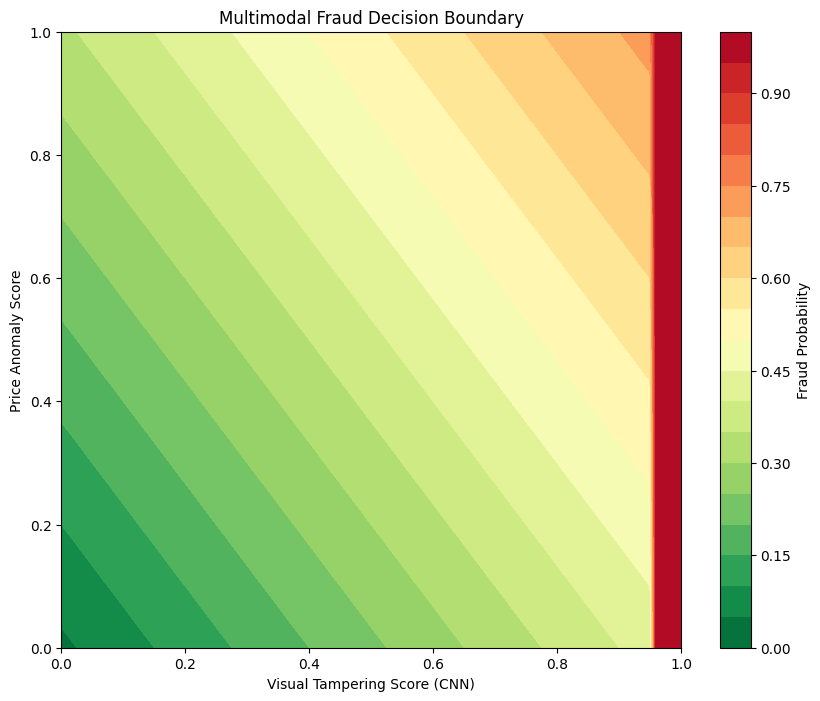

In [1]:
# %%
# 0. INSTALL DEPENDENCIES
%pip install pandas numpy matplotlib seaborn

# %% [markdown]
# # 🔗 Multimodal Fusion Engine
# This notebook demonstrates the "Weighted Logic" used to combine disparate AI signals.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %%
# 1. DEFINE FUSION LOGIC
# We use a weighted sum approach with "Hard Rule" overrides.

def fuse_scores(cnn_score, nlp_risk, amount_anomaly, metadata_flag):
    """
    Inputs:
    - cnn_score: 0.0 to 1.0 (Probability of image editing)
    - nlp_risk: 0.0 to 1.0 (Lack of medical context)
    - amount_anomaly: 0.0 to 1.0 (High deviation in price)
    - metadata_flag: 0 or 1 (Photoshop detected)
    """
    
    # Weights (Must sum to ~1.0)
    w_cnn = 0.40   # Visual evidence is strongest
    w_amt = 0.30   # Financial anomaly is second
    w_nlp = 0.20   # Context mismatch
    w_meta = 0.10  # Metadata is a binary support signal
    
    # Weighted Sum
    base_score = (cnn_score * w_cnn) + (nlp_risk * w_nlp) + \
                 (amount_anomaly * w_amt) + (metadata_flag * w_meta)
    
    # --- HARD RULES (The "Red Flags") ---
    
    # Rule 1: Metadata confirms Photoshop -> Instant High Fraud
    if metadata_flag == 1:
        base_score = max(base_score, 0.90)
        
    # Rule 2: CNN is extremely confident -> Trust the vision model
    if cnn_score > 0.95:
        base_score = max(base_score, 0.98)
        
    return min(base_score, 1.0)

# %%
# 2. SIMULATE CASES
# Let's test the logic against 3 hypothetical scenarios

scenarios = [
    # Case 1: Genuine Bill
    {"id": "CLM-001", "cnn": 0.02, "nlp": 0.1, "amt": 0.0, "meta": 0, "desc": "Genuine"},
    
    # Case 2: Photoshop Forgery
    {"id": "CLM-002", "cnn": 0.89, "nlp": 0.3, "amt": 0.1, "meta": 1, "desc": "Photoshop Edit"},
    
    # Case 3: Soft Fraud (Real bill, but inflated price)
    {"id": "CLM-003", "cnn": 0.10, "nlp": 0.1, "amt": 0.85, "meta": 0, "desc": "Price Inflation"},
]

results = []
for case in scenarios:
    final_score = fuse_scores(case['cnn'], case['nlp'], case['amt'], case['meta'])
    results.append({
        "Claim ID": case['id'],
        "Description": case['desc'],
        "Final Score": round(final_score, 4),
        "Decision": "REJECT" if final_score > 0.7 else "APPROVE"
    })

# %%
# 3. DISPLAY RESULTS
df = pd.DataFrame(results)
print("--- Fusion Decisions ---")
print(df)

# %%
# 4. VISUALIZE DECISION BOUNDARY (Heatmap)
# We plot how "Visual Tampering" vs "Price Anomaly" affects the decision.
# Red area = Fraud, Green area = Safe.

cnn_vals = np.linspace(0, 1, 100)
amt_vals = np.linspace(0, 1, 100)
X, Y = np.meshgrid(cnn_vals, amt_vals)
Z = np.zeros_like(X)

for i in range(100):
    for j in range(100):
        # Assume low NLP risk and no metadata for this plot
        Z[i, j] = fuse_scores(X[i,j], 0.2, Y[i,j], 0)

plt.figure(figsize=(10, 8))
# Reversed Red-Yellow-Green map (Red=High Score)
contour = plt.contourf(X, Y, Z, levels=20, cmap='RdYlGn_r') 
plt.colorbar(contour, label="Fraud Probability")
plt.xlabel("Visual Tampering Score (CNN)")
plt.ylabel("Price Anomaly Score")
plt.title("Multimodal Fraud Decision Boundary")
plt.show()